This code was adapted from https://www.tensorflow.org/text/tutorials/classify_text_with_bert.<br>
There is a an error when fine-tuning, possibly a shape mismatch. 

In [ ]:
! pip install tensorflow

In [ ]:
! pip install matplotlib
! pip install pandas
! pip install numpy
! pip install sklearn

In [1]:
import os

In [8]:
### requires test.ft.txt and train.ft.txt from https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
#   is downloaded and extracted to local directory or uploaded to colab runtime
# check for directory structure needed for tf.keras.utils.text_dataset_from_directory
# if directories not found, create directories and files from original .txt files
# runtime on local machine: approx 15-20 minutes
if not os.path.isdir('AmazonReviews'):
    os.mkdir('AmazonReviews')
    count = 1
    if not os.path.isdir('AmazonReviews/train'):
        os.mkdir('AmazonReviews/train')
        os.mkdir('AmazonReviews/train/neg')
        os.mkdir('AmazonReviews/train/pos')
        with open('train.ft.txt', mode='r', encoding='utf-8') as f_read:
            eof = False
            while not eof:
                text_split = []
                #append_list = []
                text = f_read.readline()
                if text == '':
                    eof = True
                else:
                    text_split = text.split(' ')
                    label = text_split[0]
                    if label[-1] == '1':
                        write_path = 'AmazonReviews/train/neg/'
                    else:
                        write_path = 'AmazonReviews/train/pos/'
                    #append_list = [i for i in text_split[1:-1]]
                    #append_text = ' '.join(append_list)
                    #new_append = re.sub(r'[^\w\s]', '', append_text)
                    append_text = text[11:]
                    write_path += str(count) + '.txt'
                    with open(write_path, mode='w', encoding='utf-8') as f_write:
                        f_write.write(append_text)
                    count += 1
    if not os.path.isdir('AmazonReviews/test'):
        os.mkdir('AmazonReviews/test')
        os.mkdir('AmazonReviews/test/neg')
        os.mkdir('AmazonReviews/test/pos')
        with open('test.ft.txt', mode='r', encoding='utf-8') as f_read:
            eof = False
            while not eof:
                text_split = []
                #append_list = []
                text = f_read.readline()
                if text == '':
                    eof = True
                else:
                    text_split = text.split(' ')
                    label = text_split[0]
                    if label[-1] == '1':
                        write_path = 'AmazonReviews/test/neg/'
                    else:
                        write_path = 'AmazonReviews/test/pos/'
                    #append_list = [i for i in text_split[1:-1]]
                    #append_text = ' '.join(append_list)
                    #new_append = re.sub(r'[^\w\s]', '', append_text)
                    append_text = text[11:]
                    write_path += str(count) + '.txt'
                    with open(write_path, mode='w', encoding='utf-8') as f_write:
                        f_write.write(append_text)
                    count += 1

In [ ]:
### if running in colab, uncomment below to run the following installs
#! pip install -q -U "tensorflow-text==2.8.*"
#! pip install -q tf-models-official==2.7.0

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [11]:
# check if GPU(s) available and use if they are
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
# load dataset from directory, split training into train/validation (80/20)
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'AmazonReviews/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'AmazonReviews/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'AmazonReviews/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3600000 files belonging to 2 classes.
Using 2880000 files for training.
Found 3600000 files belonging to 2 classes.
Using 720000 files for validation.
Found 400000 files belonging to 2 classes.


In [ ]:
for text_bat, label_bat in train_ds.take(1):
  for i in range(5):
    print(f'Review: {text_bat.numpy()[i]}')
    label = label_bat.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

In [13]:
# set paths for encoder and preprocessor
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_encode = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [14]:
# load encoder and processor from paths above
bert_preprocess_model = hub.KerasLayer(tfhub_preprocess)
bert_model = hub.KerasLayer(tfhub_encode)

In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_encode, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [16]:
text_test = ['this is such an amazing movie!']

In [17]:
# look at outputs from text preprocessing layer
text_preprocessed = bert_preprocess_model(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
# visualize BERT model outputs
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_encode}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.1861189   0.36673838  0.15233721  0.65504515
  0.9681153  -0.9486271   0.00216133 -0.9877732   0.06842745 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894633   0.34321198  0.33231443 ...  0.2130091   0.7102075
  -0.05771086]
 [-0.28742015  0.31981093 -0.23018512 ...  0.5845504  -0.21329693
   0.72692025]
 [-0.66156995  0.6887682  -0.87433    ...  0.1087732  -0.26173237
   0.47855455]
 ...
 [-0.22561154 -0.28925592 -0.07064401 ...  0.47566026  0.8327717
   0.4002531 ]
 [-0.29824257 -0.27473128 -0.05450523 ...  0.4884977   1.0955361
   0.18163356]
 [-0.4437815   0.00930723  0.07223769 ...  0.1729011   1.1833247
   0.07898059]]


In [19]:
# build classifier, test output using text_test
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.57457846]], shape=(1, 1), dtype=float32)


In [20]:
# set loss and metrics for binary classification
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [24]:
# create adamw optimizer
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [25]:
# compile model
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [26]:
# fine-tune model
# approx runtime with 8Gb GPU was 6 hours/epoch - reduce training dataset size to decrease runtime
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/3
90000/90000 [==============================] - 24593s 273ms/step - loss: 0.1342 - binary_accuracy: 0.9425 - val_loss: 0.1216 - val_binary_accuracy: 0.9593
Epoch 2/3
90000/90000 [==============================] - 23701s 263ms/step - loss: 0.1056 - binary_accuracy: 0.9642 - val_loss: 0.1185 - val_binary_accuracy: 0.9623
Epoch 3/3
90000/90000 [==============================] - 23690s 263ms/step - loss: 0.0882 - binary_accuracy: 0.9721 - val_loss: 0.1233 - val_binary_accuracy: 0.9638


In [27]:
# evaluate model on test set
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

12500/12500 [==============================] - 1521s 122ms/step - loss: 0.1233 - binary_accuracy: 0.9640
Loss: 0.123347207903862
Accuracy: 0.9640424847602844


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


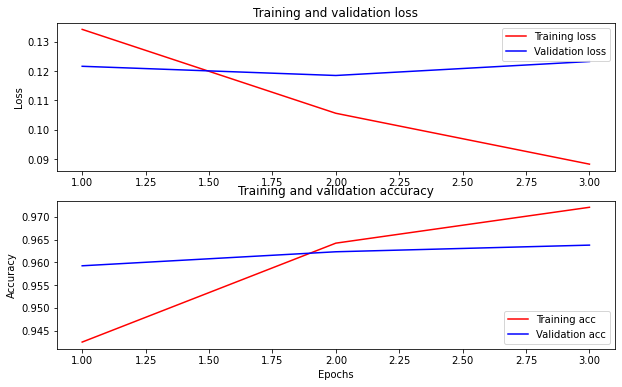

In [28]:
# print train and validation loss/accuracy
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [39]:
# test simple, negative review with mixed sentiment
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = ['I wish I could say this product was great',
            'this product is not great']
results = tf.sigmoid(classifier_model(tf.constant(examples)))
print_my_examples(examples, results)

input: I wish I could say this product was great : score: 0.980447
input: this product is not great      : score: 0.004347



In [29]:
# save model for future use
dataset_name = 'amazon_reviews'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)